Tutorial 3: Inversions
======================

We've covered _Mapper_'s, which, if I haven't emphasised it enough yet, map things. Now, we're going to look at how we
can use these _Mapper_'s (which map things) to reconstruct the source galaxy - I hope you're excited!

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


We'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's _MassProfile_ is an _EllipticalIsothermal_.
 - The source galaxy's _LightProfile_ is an _EllipticalSersic_.

In [2]:
from howtolens.simulators.chapter_4 import lens_sie__source_sersic

dataset_type = "chapter_4"
dataset_name = "lens_sie__source_sersic"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

Lets create an annular _Mask_ which traces the stongly lensed source ring.

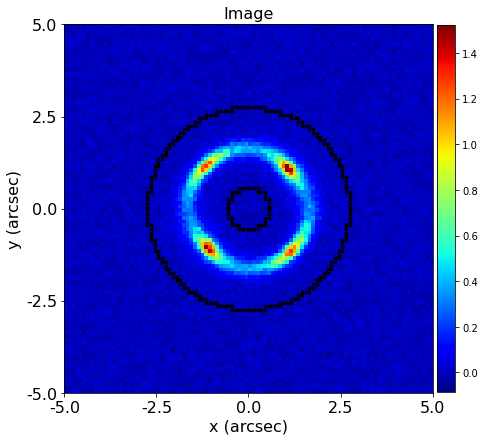

In [3]:
mask = al.Mask.circular_annular(
    shape_2d=imaging.shape_2d,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    inner_radius=0.5,
    outer_radius=2.8,
)

aplt.Imaging.image(imaging=imaging, mask=mask)

Next, lets set the _Imaging_ and _Mask_ up as a _MaskedImaging_ object and setup a _Tracer_ using the input lens 
galaxy model (we don't need to provide the source's _LightProfile_, as we're using a _Mapper_ to reconstruct it).

In [4]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.1, 0.0), einstein_radius=1.6
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

We'll use another rectangular _Pixelization_ and _Mapper_ to perform the reconstruction.

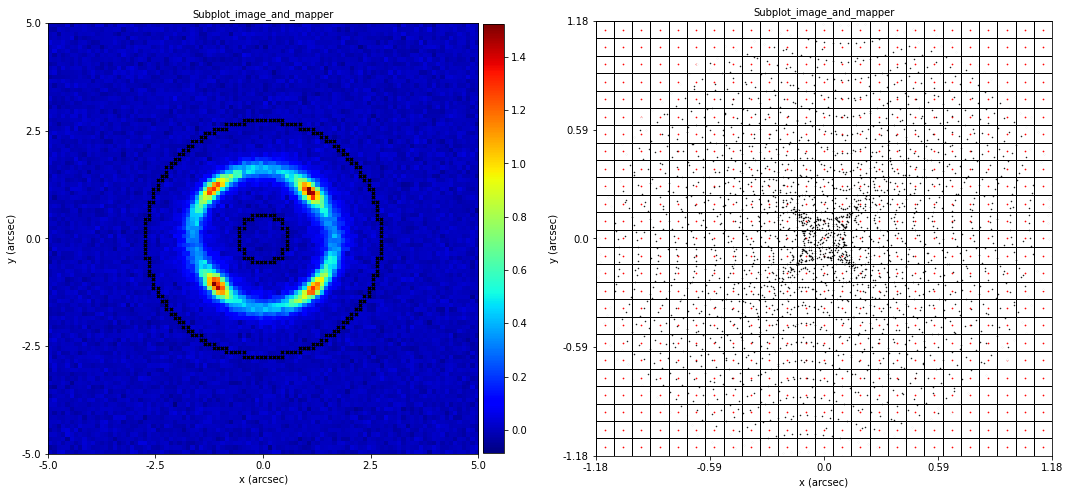

In [6]:
rectangular = al.pix.Rectangular(shape=(25, 25))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we're going to use our _Mapper_ to invert the image using an _Inversion_. I'll explain how this 
works in a second - but lets just go ahead and use the _Inversion_ first. (Ignore the 'regularization' input below for 
now, we'll cover this in the next tutorial).

In [7]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)

Our _Inversion_ has a reconstructed image and _Pixeilzation_, whcih we can plot using an _Inversion_ plotter

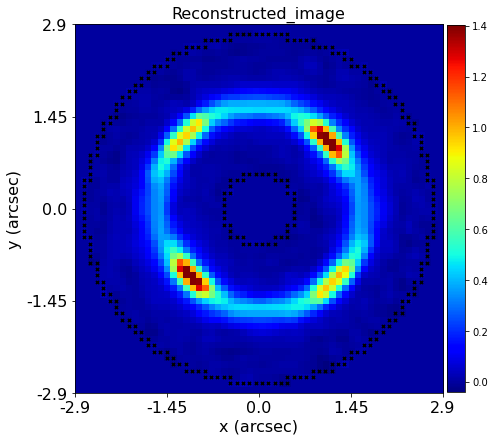

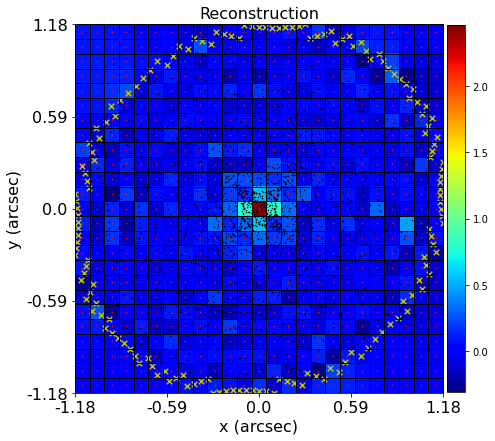

In [8]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_grid=True)
)

And there we have it, we've successfully reconstructed, or, *inverted*, our source using the mapper's rectangular 
grid. Whilst this source was simple (a blob of light in the centre of the source-plane), _Inversion_'s come into their 
own when fitting sources with complex morphologies. Infact, given we're having so much fun inverting things, lets 
invert a really complex source!

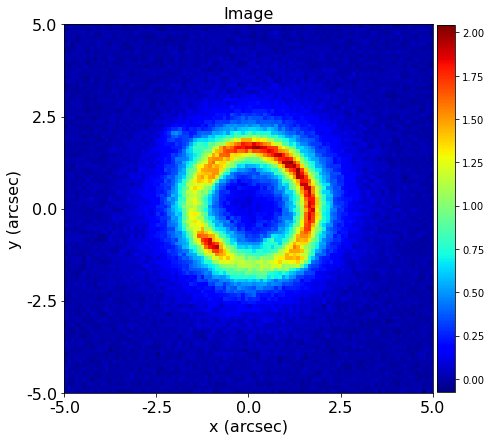

In [9]:
from howtolens.simulators.chapter_4 import lens_sie__source_sersic_x5

dataset_type = "chapter_4"
dataset_name = "lens_sie__source_sersic_x5"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

aplt.Imaging.image(imaging=imaging)

This code is doing all the the same as above (setup the _Mask_, _Galaxy_'s _Tracer_, _Mapper_, ec.).

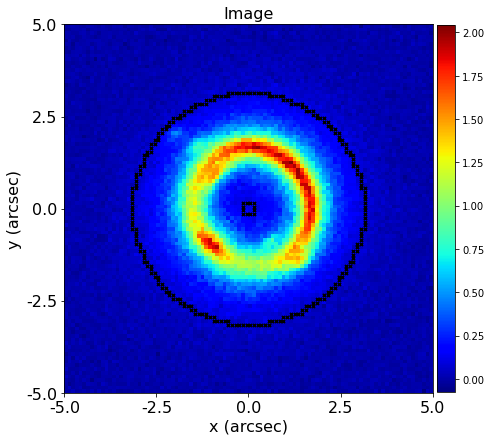

In [10]:

mask = al.Mask.circular_annular(
    shape_2d=imaging.shape_2d,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    inner_radius=0.1,
    outer_radius=3.2,
)

aplt.Imaging.image(imaging=imaging, mask=mask)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)

Lets inspect the complex source reconstruction.

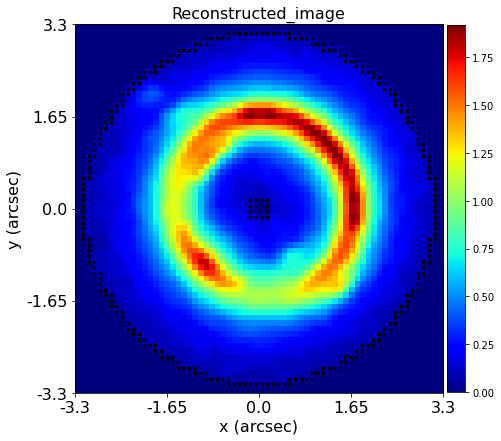

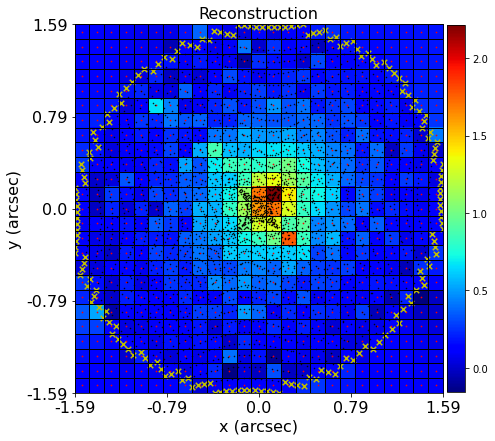

In [11]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_grid=True)
)


Pretty great, huh? If you ran the complex source pipeline, you'll remember that getting a model image that looked that 
good simply *was not possible*. With an _Inversion_, we can do it with ease and without fitting 30+ parameters!

Lets discuss how an _Inversion_ actually works. The explanation I give below is overly-simplified. I'm avoiding the 
technical details of how an _Inversion_ *actually* works. To be good at lens modeling you don't need to understand the 
nitty-gritty details of linear inversions, you just need an instinct for how to use them as a tool to model lenses.

Nevertheless, I know a lot of you hate 'black-boxes', or have an interest in linear algrebra. If you're that way 
inclined, then checkout the documentation of the autolens source code for more information. In particular, you should 
look at the following functions in the project PyAutoArray:

autoarray.operators.inversions.mappers.mapping_matrix
autoarray.opterators.convolution.convolve_mapping_matrix
autoarray.opterators.inversions.regularization.Regularization
autoarray.opterators.inversions.inversions.Inversion

To begin, lets consider some random mappings between our mapper's source-pixels and the image.

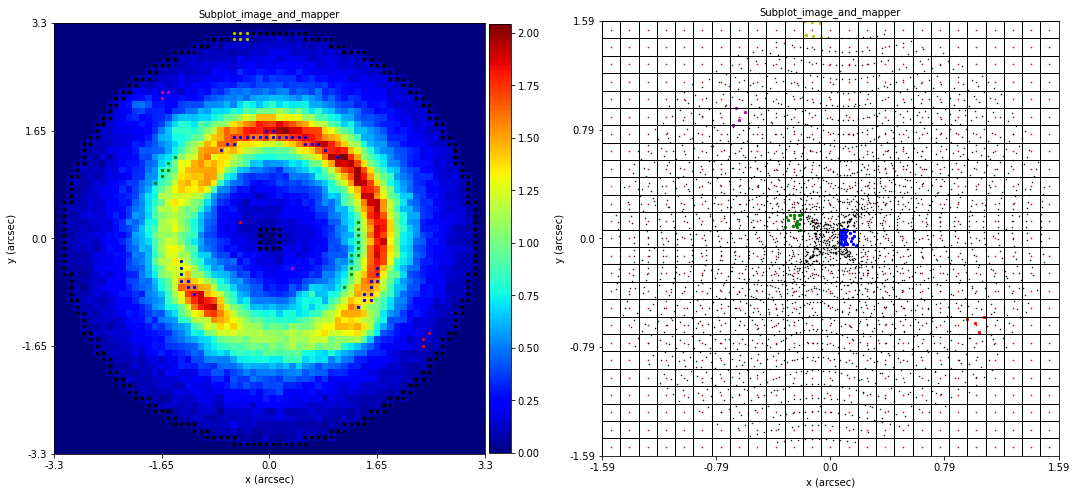

In [12]:
aplt.Mapper.subplot_image_and_mapper(
    image=masked_imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
    source_pixel_indexes=[[445], [285], [313], [132], [11]],
)

These mappings are known before the _Inversion_, which means pre-inversion we know two key pieces of information:

    1) The mappings between every source-pixel and sets of image-pixels.
    2) The flux values in every observed image-pixel, which are the values we want to fit successfully.

It turns out that with these two pieces of information we can linearly solve for the set of source-pixel fluxes that 
best-fit (e.g. maximize the log likelihood of) our observed image. Essentially, we set up the mapping between source and 
image pixels as a large matrix and solve for the source-pixel fluxes in an analogous fashion to how you would solve a 
set of simultaneous linear equations. This process is called a 'linear inversion'.

There are three more things about a linear _Inversion_ that are worth knowing:

    1) We've discussed the image sub-grid before, which splits each image-pixel into a sub-pixel. If a sub-grid is 
       used, it is the mapping between every sub-pixel and source-pixel that is computed and used to perform the 
       inversion. This prevents aliasing effects degrading the image reconstruction, and, as a rule of thumb, I 
       would suggest you use sub-gridding of degree 2x2.

    2) When fitting using _LightProfile_'s we discussed how a 'model_image' was generated by blurring them with the 
       data's PSF. A similar blurring operation is incorporated into the _Inversion_, such that the reconstructed 
       image and source fully account for the telescope optics and effect of the PSF.

    3) The inversion's solution is regularized. But wait, that's what we'll cover in the next tutorial!

Finally, let me show you how easy it is to fit an image with an _Inversion_ using a _FitImaging_ oboject. Instead of 
giving the source galaxy a _LightProfile_, we give it a _Pixelization_and _Regularization_, and pass it to a _Tracer_.

In [21]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Then, like before, we pass the _MaskedImaging_ and _Tracer_ to a _FitImaging_ object. Indeed, we see some 
pretty good looking residuals - we're certainly fitting the lensed source accurately!

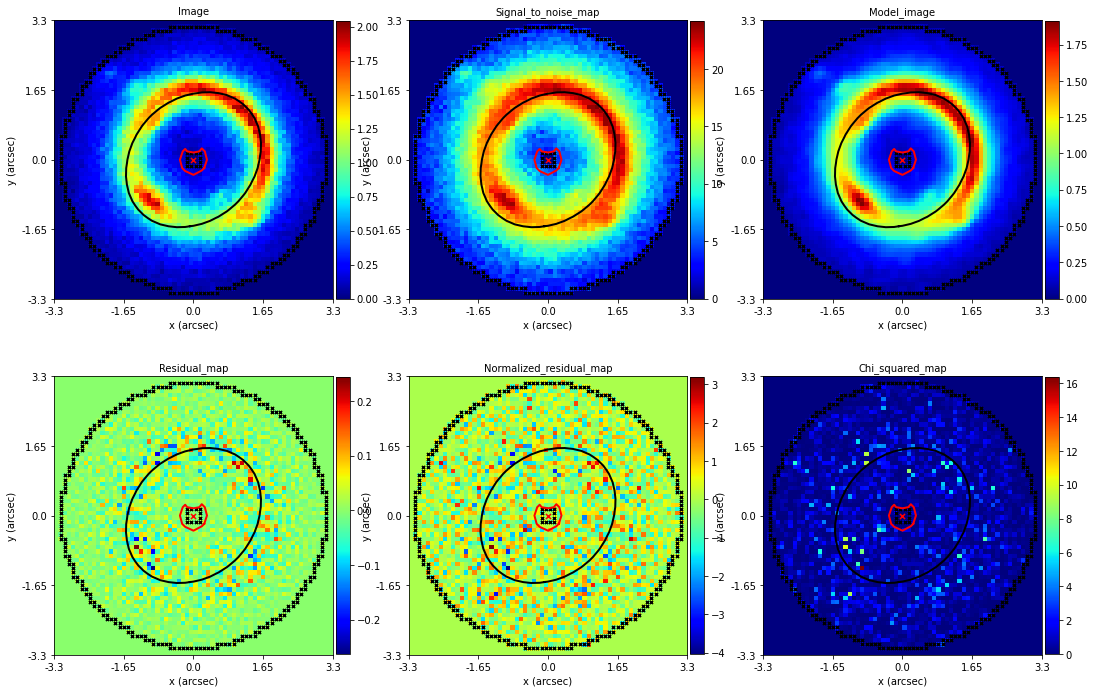

In [22]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))

And, we're done, here are a few questions to get you thinking about _Inversion_'s:

1) The _Inversion_ provides the maximum log likelihood solution to the observed image. Is there a problem with seeking 
   the 'best-fit'? Is there a risk that we're going to fit other things in the image than just the lensed source 
   galaxy? What happens if you reduce the 'regularization_coefficient' above to zero?

2) The exterior pixels in the _Rectangular_ _Grid_ have no image-pixels in them. However, they are still given a 
   reconstructed flux. If this value isn't' coming from a util to an image-pixel, where is it be coming from?